https://www.kaggle.com/datasets/mohamedgobara/multi-class-knee-osteoporosis-x-ray-dataset \
https://www.kaggle.com/datasets/vuppalaadithyasairam/bone-fracture-detection-using-xrays \
https://www.kaggle.com/datasets/daverattan/dental-xrary-tfrecords \
https://www.kaggle.com/datasets/yovinyahathugoda/x-ray-body-part-dataset-512x512

### V2: outputs variable # of patches according to input

# Setup

In [97]:
import sys
sys.path.append("/Users/ms/cs/ML/SingleImageINR/MedDINOv3/nnUNet")

from nnunetv2.training.nnUNetTrainer.dinov3.dinov3.models.vision_transformer import vit_base

# import nnunetv2.training.nnUNetTrainer.dinov3.dinov3.models.vision_transformer
# from nnunetv2.training.nnUNetTrainer.dinov3.dinov3.models.vision_transformer import vit_base

In [98]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision import transforms

# --- Device ---
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [99]:
# --- Initialize the ViT backbone ---
model = vit_base(
    drop_path_rate=0.0,
    layerscale_init=1.0e-05,
    n_storage_tokens=4,
    qkv_bias=False,
    mask_k_bias=True,
    pos_embed_rope_dtype="fp32",
    norm_layer="layernormbf16",    
)

# --- Load MedDINOv3 pretrained weights ---
chkpt = torch.load("/home/minsukc/SIO/meddino_model.pth", map_location="cpu")

# If the checkpoint dict contains nested keys, extract the "teacher" weights if needed
if "teacher" in chkpt:
    chkpt = chkpt["teacher"]

# model.load_state_dict(chkpt, strict=True)
# model.to(device).eval()

# print("✅ MedDINOv3 loaded successfully.")

# remove the "backbone." prefix if present
new_chkpt = {}
for k, v in chkpt.items():
    if k.startswith("backbone."):
        new_chkpt[k[len("backbone."):]] = v
    else:
        new_chkpt[k] = v

# load in float32
for k, v in new_chkpt.items():
    new_chkpt[k] = v.float()

model.load_state_dict(new_chkpt, strict=True)
model.to(device, dtype=torch.float32).eval()

print("✅ MedDINOv3 backbone loaded successfully.")

/tmp/ipykernel_734654/2498350318.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chkpt = torch.load("/home/minsukc/SIO/meddino_model.pth", map_location="cpu")


✅ MedDINOv3 backbone loaded successfully.


In [100]:
# --- Image setup ---
data_dir = "/home/minsukc/SIO/data/"
# target_image = "ct_chest_1.jpeg"
# target_image = "ct_chest_2.png"
# target_image = "ct_abdomen_2.png"  
# target_image = "ct_bone_1.jpg"  
target_image = "Chest_CT_Slice_1.png"  
# target_image = "_dog.jpg"  
img_path = os.path.join(data_dir, target_image)

# --- Preprocessing ---
preprocess = transforms.Compose([
    transforms.Resize((768, 768)),  # larger input for dense patch grid
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image = Image.open(img_path).convert("RGB")
inputs = preprocess(image).unsqueeze(0).to(device)  # type: ignore # shape [1, 3, 768, 768]

# [CLS] Token Attention Map

In [101]:
# Author's code does not store the raw attention weights → hard to do CLS visualization

In [102]:
# -----------------------------
# CLS → Patch Attention (Capture via Hook)
# -----------------------------
attn_map = {}

def capture_last_attn(module, input, output):
    """
    Extract raw attention weights from the last SelfAttention layer.
    """
    x = input[0]  # [B, N, C]
    B, N, C = x.shape
    qkv = module.qkv(x)
    qkv = qkv.reshape(B, N, 3, module.num_heads, C // module.num_heads).permute(2, 0, 3, 1, 4)
    q, k, _ = qkv[0], qkv[1], qkv[2]
    attn = (q @ k.transpose(-2, -1)) * module.scale
    attn = attn.softmax(dim=-1)
    attn_map["last"] = attn.detach().cpu()  # shape [B, heads, N, N]

# Register hook on the *last* block's attention
hook_handle = model.blocks[-1].attn.register_forward_hook(capture_last_attn)

with torch.no_grad():
    feats = model.forward_features(inputs)
hook_handle.remove()


patch_feats = feats["x_norm_patchtokens"].squeeze(0)  # type: ignore # [N_patches, D]
cls_feat = feats["x_norm_clstoken"].unsqueeze(0)      # type: ignore # [1, D]

print("patch_feats:", patch_feats.shape)
print("cls_feat:", cls_feat.shape)
print(torch.isnan(feats["x_norm_patchtokens"]).any()) # type: ignore


patch_feats: torch.Size([2304, 768])
cls_feat: torch.Size([1, 1, 768])
tensor(False, device='cuda:0')


In [103]:
# Average across heads
attn = attn_map["last"].mean(dim=1)[0]  # [N, N]

num_registers = model.n_storage_tokens  # usually 4
cls_to_patches = attn[0, 1 + num_registers:]  # skip CLS + register tokens

patch_h = patch_w = int(patch_feats.shape[0] ** 0.5)
cls_to_patches = cls_to_patches.reshape(patch_h, patch_w)
cls_to_patches = (cls_to_patches - cls_to_patches.min()) / (cls_to_patches.max() - cls_to_patches.min() + 1e-8)


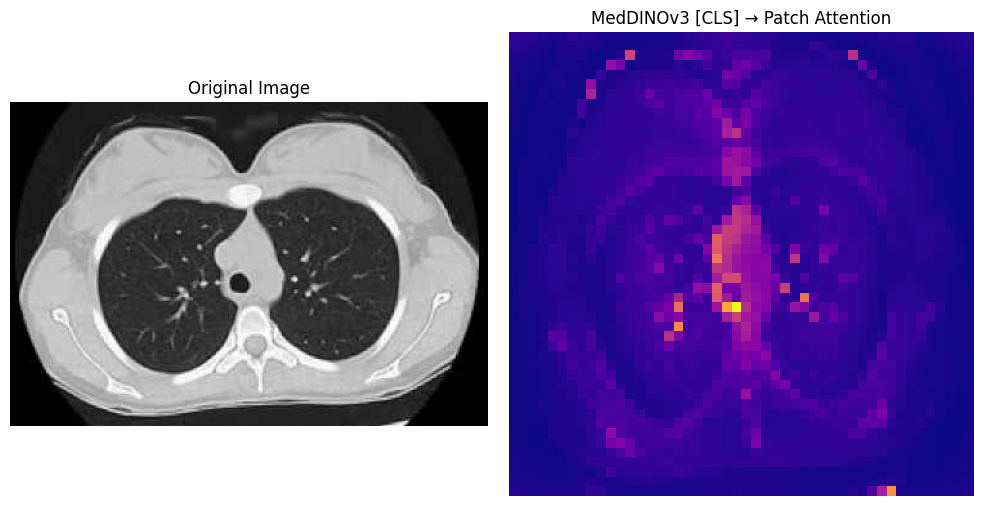

In [104]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cls_to_patches, cmap="plasma", interpolation="nearest")
plt.title("MedDINOv3 [CLS] → Patch Attention")
plt.axis("off")
plt.tight_layout()
plt.show()


# Patch Similarity Map

In [124]:
num_patches = patch_feats.shape[0]
patch_side = int(num_patches ** 0.5)

# pick a few query patches (grid positions)
grid_size = 4
coords = np.linspace(0, patch_side - 1, grid_size, dtype=int)
query_indices = [y * patch_side + x for y in coords for x in coords]
print(patch_side)

48


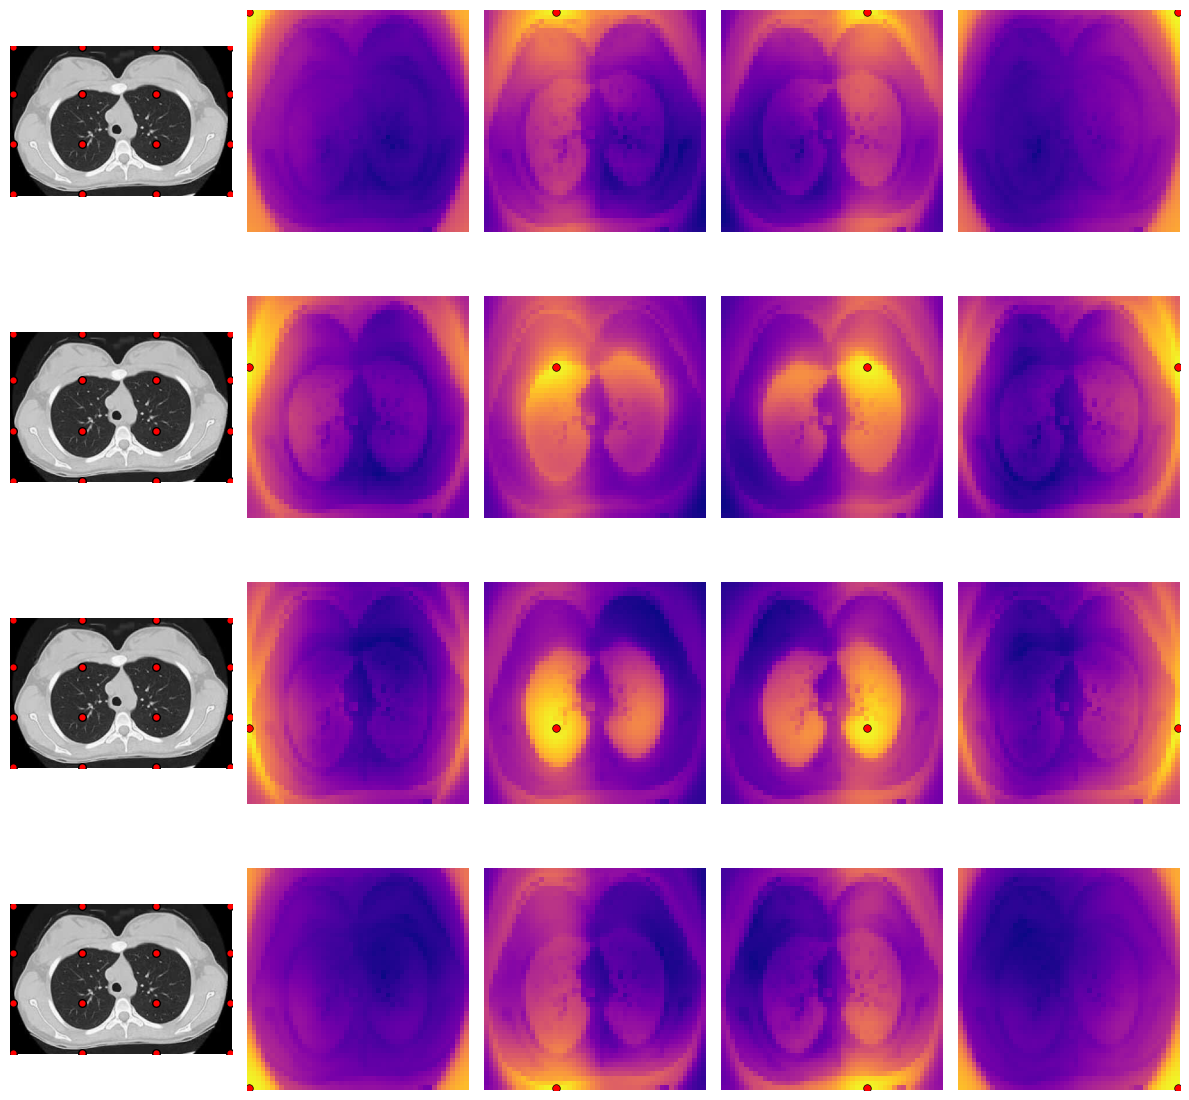

In [106]:
fig, axes = plt.subplots(grid_size, grid_size + 1, figsize=(12, 12))

# Left column: original image with red markers
for r in range(grid_size):
    ax = axes[r, 0]
    ax.imshow(image)
    ax.axis("off")
    for idx in query_indices:
        y, x = divmod(idx, patch_side)
        ax.scatter(
            (x + 0.5) * (image.width / patch_side),
            (y + 0.5) * (image.height / patch_side),
            color="red", s=30, edgecolors="black"
        )

# Right columns: similarity maps
for r in range(grid_size):
    for c in range(grid_size):
        idx = query_indices[r * grid_size + c]
        query_feat = patch_feats[idx:idx+1]
        sim = torch.nn.functional.cosine_similarity(query_feat, patch_feats)
        sim = sim.reshape(patch_side, patch_side).cpu().numpy()
        sim = (sim - sim.min()) / (sim.max() - sim.min() + 1e-8)
        ax = axes[r, c + 1]
        ax.imshow(sim, cmap="plasma", interpolation="nearest", vmin=0, vmax=1)
        qy, qx = divmod(idx, patch_side)
        ax.scatter(
            qx, qy,
            color="red", s=30, edgecolors="black", linewidth=0.5
        )
        ax.axis("off")

plt.tight_layout()
plt.show()

# PCA

In [107]:
from sklearn.decomposition import PCA

feats = patch_feats.cpu().numpy()
pca = PCA(n_components=3)
pca_feats = pca.fit_transform(feats)
pca_feats = (pca_feats - pca_feats.min(0)) / (pca_feats.max(0) - pca_feats.min(0) + 1e-8)

patch_h = patch_w = int(np.sqrt(len(pca_feats)))
pca_img = pca_feats.reshape(patch_h, patch_w, 3)

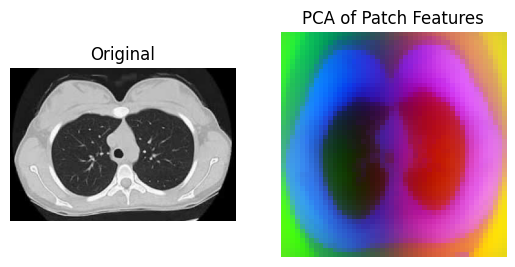

In [108]:
plt.subplot(1,2,1)
plt.imshow(image)
plt.axis("off")
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(pca_img, interpolation="nearest")
plt.axis("off")
plt.title("PCA of Patch Features")
plt.show()